In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import pandas as pd

/tmp/ipykernel_3408700/2817862154.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
df = pd.read_csv('experiment_results.csv')
df.head()

,dataset,algo,use_contrastive,seed,agent_id,avg_acc,final_acc,forward,backward
0,cifar100,monolithic,True,seed_0,agent_1,0.578813,0.6029,0.168250,-0.025380
1,cifar100,monolithic,True,seed_0,agent_2,0.563768,0.5611,0.206500,-0.029609
2,cifar100,monolithic,True,seed_0,agent_3,0.585666,0.5715,0.182875,-0.029707
3,cifar100,monolithic,True,seed_0,agent_0,0.575715,0.5736,0.191625,-0.029435
4,cifar100,modular,False,seed_0,agent_1,0.802707,0.8145,0.203375,-0.000109


In [3]:
m = df.groupby(["algo", "dataset", "use_contrastive"])[
      "final_acc"].mean()
stderr = df.groupby(["algo", "dataset", "use_contrastive"])["final_acc"].sem()
m

algo        dataset   use_contrastive
modular     cifar100  False              0.810325
                      True               0.805500
monolithic  cifar100  False              0.556425
                      True               0.577275
Name: final_acc, dtype: float64

In [23]:
stderr

algo        dataset   use_contrastive
modular     cifar100  False              0.001548
                      True               0.005765
monolithic  cifar100  False              0.006446
                      True               0.008968
Name: final_acc, dtype: float64

In [19]:
# modular_means when algo == "modular" and use_contrastive == False
# datasets = ['mnist', 'fashionmnist', 'kmnist', 'cifar100']
datasets = ['cifar100']

modular_means = [m[('modular', dataset, False)] for dataset in datasets]
modular_stderr = [stderr[('modular', dataset, False)] for dataset in datasets]

modular_contrastive_means = [m[('modular', dataset, True)] for dataset in datasets]
modular_contrastive_stderr = [stderr[('modular', dataset, True)] for dataset in datasets]

monolithic_means = [m[('monolithic', dataset, False)] for dataset in datasets]
monolithic_stderr = [stderr[('monolithic', dataset, False)] for dataset in datasets]

monolithic_contrastive_means = [m[('monolithic', dataset, True)] for dataset in datasets]
monolithic_contrastive_stderr = [stderr[('monolithic', dataset, True)] for dataset in datasets]

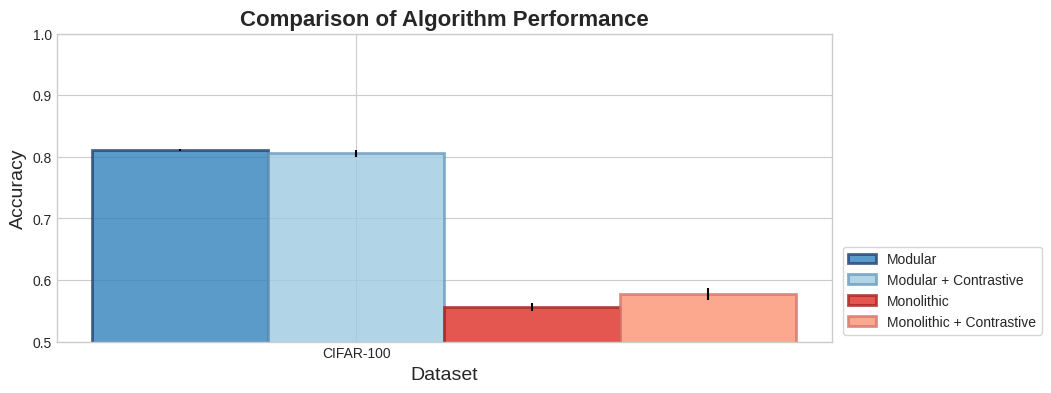

In [21]:


# Set colors
modular_color = '#3182bd'
modular_contrastive_color = '#9ecae1'
monolithic_color = '#de2d26'
monolithic_contrastive_color = '#fc9272'

# Set figure size
fig, ax = plt.subplots(figsize=(10,4))

# Plot data
bar_width = 0.2
opacity = 0.8

# fake ChatGPT data
# modular_means = [93.5, 90.8, 93.7, 71.3, 91.8, 76.4]
# modular_std = [1.1, 0.8, 0.5, 1.2, 0.5, 1.4]

# actual data
# modular_means = [93.5, 90.8, 93.7, 71.3, 91.8, 76.4]
# modular_std = [1.1, 0.8, 0.5, 1.2, 0.5, 1.4]

# modular_contrastive_means = [94.2, 91.6, 93.9, 74.5, 93.4, 77.5]
# modular_contrastive_std = [0.9, 0.7, 0.6, 1.1, 0.7, 1.1]

# monolithic_means = [92.6, 89.4, 92.7, 68.1, 91.0, 74.8]
# monolithic_std = [0.7, 0.9, 0.6, 1.1, 0.8, 0.9]

# monolithic_contrastive_means = [94.3, 91.7, 94.2, 74.8, 94.0, 79.3]
# monolithic_contrastive_std = [0.8, 0.6, 0.4, 0.8, 0.5, 0.9]

linewidth = 2

rects1 = ax.bar(np.arange(len(modular_means))-bar_width, modular_means, bar_width,
                yerr=modular_stderr, alpha=opacity, color=modular_color, label='Modular',
                edgecolor='#214073',
                 linewidth=linewidth,
              )
rects2 = ax.bar(np.arange(len(modular_contrastive_means)), modular_contrastive_means, bar_width,
                yerr=modular_contrastive_stderr, alpha=opacity, color=modular_contrastive_color, label='Modular + Contrastive',
                edgecolor='#6a9bbd',
                 linewidth=linewidth,
                )
rects3 = ax.bar(np.arange(len(monolithic_means))+bar_width, monolithic_means, bar_width,
                yerr=monolithic_stderr, alpha=opacity, color=monolithic_color, label='Monolithic',
                edgecolor='#a6221f',
                                linewidth=linewidth,)
rects4 = ax.bar(np.arange(len(monolithic_contrastive_means))+bar_width*2, monolithic_contrastive_means, bar_width,
                yerr=monolithic_contrastive_stderr, alpha=opacity, color=monolithic_contrastive_color, label='Monolithic + Contrastive',
                 edgecolor='#d4756d',
                 linewidth=linewidth,
                 )


# datasets = ['MNIST', 'FashionMNIST', 'KMNIST', 'CIFAR-100']
datasets = ['CIFAR-100']
# datasets = ['MNIST', 'FashionMNIST', 'KMNIST', 'CIFAR-100', 'Gridworld', 'Composuite']
x = np.arange(len(datasets))
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_xlabel('Dataset', fontsize=14)
# leg = ax.legend(frameon=True)
# leg.get_frame().set_edgecolor('b')

ax.set_title('Comparison of Algorithm Performance', fontsize=16, fontweight='bold')


# ax.legend(frameon=True, loc='lower center')
ax.legend(frameon=True, loc='lower right', bbox_to_anchor=(1.28, 0.0));
plt.savefig(f"Figures/vanilla/results.pdf", bbox_inches="tight")
# plt.tight_layout()
# https://arxiv.org/pdf/2303.03378.pdf, color around box, see Figure 6